In [80]:
import sqlite3
from xml.etree.ElementTree import ParseError
from tqdm import tqdm
import os
import sys
sys.path.append("../..")

import importlib
module = importlib.import_module('utils.ecg_utils')
importlib.reload(module)
from utils.ecg_utils import parse_date, plot_ecg_signal

In [24]:
import importlib
module = importlib.import_module("utils.ecg_utils")
importlib.reload(module)

<module 'utils.ecg_utils' from '/work/users/y/u/yuukias/BIOS-Material/BIOS992/script/../utils/ecg_utils.py'>

In [4]:
ECG_folder = "/users/y/u/yuukias/database/UKBiobank/6025"

## Time of ECG Recording

In [3]:
from utils.constants import db_file, processed_table_name, primary_key

# create a column to store the date of the ECG recording

conn = sqlite3.connect(db_file)
cursor = conn.cursor()

In [34]:
update_sql = f"""
    ALTER TABLE {processed_table_name}
    ADD COLUMN ECG_date DATE;
"""

cursor.execute(update_sql)

for file_path in tqdm(sorted(os.listdir(ECG_folder))):
    if file_path.endswith(".xml"):
        eid = file_path.split("_")[0]
        file_path = os.path.join(ECG_folder, file_path)
        try:
            date = parse_date(file_path)
            cursor.execute(f"UPDATE {processed_table_name} SET ECG_date = ? WHERE {primary_key} = ?", (date, eid))
        except ParseError:
            continue

conn.commit()

  0%|          | 0/77888 [00:00<?, ?it/s]

100%|██████████| 77888/77888 [2:21:53<00:00,  9.15it/s]  


In [10]:
# Determine how many participants who have ECG date.
query_sql = f"SELECT COUNT(*) FROM {processed_table_name} WHERE ECG_date IS NOT NULL;"
cursor.execute(query_sql)
print(cursor.fetchall())

query_sql = f"SELECT COUNT(*) FROM {processed_table_name} WHERE ECG_date IS NOT NULL AND test_status = 1;"
cursor.execute(query_sql)
print(cursor.fetchall())

# Also calculate for participants with and without CVD respectively
query_sql = f"SELECT COUNT(*) FROM {processed_table_name} WHERE ECG_date IS NOT NULL AND CVD = 1  AND test_status = 1;"
cursor.execute(query_sql)
print(cursor.fetchall())

query_sql = f"SELECT COUNT(*) FROM {processed_table_name} WHERE ECG_date IS NOT NULL AND CVD = 0  AND test_status = 1;"
cursor.execute(query_sql)
print(cursor.fetchall())

[(61927,)]
[(49608,)]
[(9077,)]
[(40531,)]


There are 15691 participants with ECG XML that are empty. The remaining 61927 can be used for the analysis.

# Main extractable variables

We will only use the maximum HR and maximum workload, which have already been provided in UK Biobank in field 6032 and 6033. Check https://biobank.ndph.ox.ac.uk/ukb/label.cgi?id=100012

# HRV indices

In [99]:
import importlib
module = importlib.import_module('utils.ecg_processor')
importlib.reload(module)
import numpy as np
from utils.ecg_processor import ECG_Processor

In [100]:
SAMPLING_RATE = 500
ID = "1000668"

We first test whether HRV nonlinear indices can be extracted.

In [101]:
ecg_processor = ECG_Processor(ECG_folder, ID)

Lead order: ['I', '2', '3']


In [260]:
signal_fragment1 = ecg_processor.get_signals('2')[:1000]
signal_fragment2 = ecg_processor.get_signals('2')[-1000:]

(<Figure size 2000x300 with 1 Axes>,
 <AxesSubplot:xlabel='Time (ms)', ylabel='Amplitude'>)

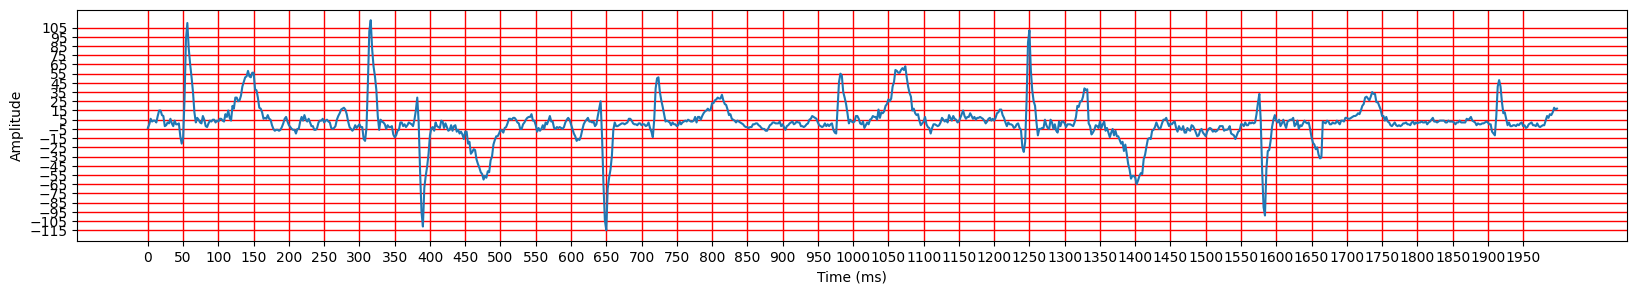

In [258]:
plot_ecg_signal(signal_fragment1)

(<Figure size 2000x300 with 1 Axes>,
 <AxesSubplot:xlabel='Time (ms)', ylabel='Amplitude'>)

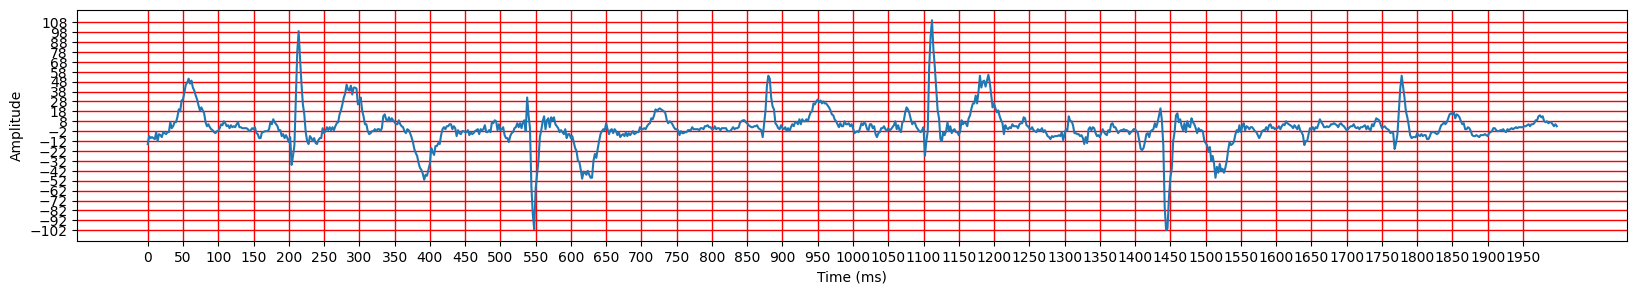

In [261]:
plot_ecg_signal(signal_fragment2)

Get relevant information from the database.

In [203]:
from utils.constants import db_file, variables_table_name, processed_table_name, primary_key

# create a column to store the date of the ECG recording

conn = sqlite3.connect(db_file)
cursor = conn.cursor()

In [114]:
query_sql = f"""
SELECT `5991-0.0`, `5991-0.1`, `5991-0.2`
FROM {variables_table_name}
LIMIT 10;
"""
cursor.execute(query_sql)
print(cursor.fetchall())

[('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest'), ('Pretest', 'Exercise', 'Rest')]


In [133]:
# phase name, array indices 0-2
query_sql = f"""
SELECT `5991-0.0`, `5991-0.1`, `5991-0.2` 
FROM {variables_table_name}
WHERE {primary_key} = {ID};
"""
cursor.execute(query_sql)
print(cursor.fetchall())


# phase duration, array indices 0-2
query_sql = f"""
SELECT `5992-0.0`, `5992-0.1`, `5992-0.2` 
FROM {variables_table_name}
WHERE {primary_key} = {ID};
"""
cursor.execute(query_sql)
print(cursor.fetchall())

# maximum workload (Watts) and maximum heart rate (beats per minute)
query_sql = f"""
SELECT `6032-0.0`, `6033-0.0`
FROM {variables_table_name}
WHERE {primary_key} = {ID};
"""
cursor.execute(query_sql)
print(cursor.fetchall())

[('Pretest', 'Exercise', 'Rest')]
[(15.0, 360.0, 60.0)]
[(70.0, 120.0)]


In [119]:
ecg_processor.get_info()

{'max_heart_rate': '120',
 'max_workload': {'@units': 'watts', '#text': '70'},
 'sampling_rate': 500}

This aligns with the information stored in the database.

Now we count the number of participants with valid XML files.

In [184]:
query_schema_sql = f"""
PRAGMA table_info({variables_table_name});
"""
cursor.execute(query_schema_sql)
columns = cursor.fetchall()

# trend phase name (pretest, exericse, ...), array indices 0-113
columns_5987 = [f"`{col[1]}`" for col in columns if "5987" in col[1]]
columns_5987_str = ", ".join(columns_5987)
query_sql = f"""
SELECT {columns_5987_str}
FROM {variables_table_name}
WHERE {primary_key} = {ID};
"""
cursor.execute(query_sql)
phase_name_raw = cursor.fetchall()[0]

# stage name (steady, constant, ...), array indices 0-113
columns_5988 = [f"`{col[1]}`" for col in columns if "5988" in col[1]]
columns_5988_str = ", ".join(columns_5988)
query_sql = f"""
SELECT {columns_5988_str}
FROM {variables_table_name}
WHERE {primary_key} = {ID};
"""
cursor.execute(query_sql)
stage_name_raw = cursor.fetchall()[0]

In [186]:
phase_name = [name for name in phase_name_raw if name and name != 'nan']
stage_name = [name for name in stage_name_raw if name and name != 'nan']
print(len(phase_name), phase_name)
print(len(stage_name), stage_name)

81 ['Pretest', 'Pretest', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest']
81 ['Steady', 'Steady', 'Constant', 'Constant', 'Constant'

In [195]:
from utils.csv_utils import get_data


['eid', '3-0.0', '3-1.0', '3-2.0', '3-3.0', '4-0.0', '4-1.0', '4-2.0', '4-3.0', '5-0.0', '5-1.0', '5-2.0', '5-3.0', '6-0.0', '6-1.0', '6-2.0', '6-3.0', '19-0.0', '21-0.0', '21-1.0', '21-2.0', '21-3.0', '31-0.0', '34-0.0', '36-0.0', '36-1.0', '36-2.0', '36-3.0', '37-0.0', '37-1.0', '37-2.0', '37-3.0', '38-0.0', '38-1.0', '38-2.0', '38-3.0', '39-0.0', '39-1.0', '39-2.0', '39-3.0', '40-0.0', '40-1.0', '40-2.0', '40-3.0', '41-0.0', '41-1.0', '41-2.0', '41-3.0', '42-0.0', '42-1.0', '42-2.0', '42-3.0', '43-0.0', '43-1.0', '43-2.0', '43-3.0', '44-0.0', '44-1.0', '44-2.0', '44-3.0', '45-0.0', '45-1.0', '45-2.0', '45-3.0', '46-0.0', '46-1.0', '46-2.0', '46-3.0', '47-0.0', '47-1.0', '47-2.0', '47-3.0', '48-0.0', '48-1.0', '48-2.0', '48-3.0', '49-0.0', '49-1.0', '49-2.0', '49-3.0', '50-0.0', '50-1.0', '50-2.0', '50-3.0', '51-0.0', '51-1.0', '51-2.0', '51-3.0', '52-0.0', '53-0.0', '53-1.0', '53-2.0', '53-3.0', '54-0.0', '54-1.0', '54-2.0', '54-3.0', '55-0.0', '55-1.0', '55-2.0', '55-3.0', '77-0.0'

In [197]:
columns_5986 = [f"5986-0.{i}" for i in range(0, 113)]

df = get_data(columns_5986)
print(df)

         eid  5986-0.0  5986-0.1  5986-0.2  5986-0.3  5986-0.4  5986-0.5  \
0    1000016      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
1    1000021      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
2    1000033      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
3    1000049      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
4    1000057      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
..       ...       ...       ...       ...       ...       ...       ...   
717  6026408      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
718  6026414      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
719  6026429      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
720  6026431      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
721  6026447      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   

     5986-0.6  5986-0.7  5986-0.8  ...  5986-0.103  5986-0.104  5986-0.105  \
0        

In [201]:
df.to_csv("../../data/5986.csv", index=False)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f89c27bf220>>
Traceback (most recent call last):
  File "/work/users/y/u/yuukias/env_conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


[(1000205,), (1000239,), (1000361,), (1000400,), (1000458,), (1000587,), (1000659,), (1000668,), (1000677,), (1000737,), (1000779,), (1000788,), (1000814,), (1000928,), (1000991,), (1001064,), (1001125,), (1001132,), (1001233,), (1001249,), (1001298,), (1001319,), (1001324,), (1001346,), (1001786,), (1001806,), (1001894,), (1001978,), (1002007,), (1002054,), (1002252,), (1002260,), (1002485,), (1002613,), (1002622,), (1002778,), (1002863,), (1002908,), (1002914,), (1002947,), (1002950,), (1003023,), (1003041,), (1003094,), (1003262,), (1003273,), (1003286,), (1003295,), (1003328,), (1003448,), (1003454,), (1003483,), (1003534,), (1003555,), (1003590,), (1003637,), (1003727,), (1003792,), (1003821,), (1003849,), (1003870,), (1003924,), (1003952,), (1003975,), (1004026,), (1004090,), (1004149,), (1004276,), (1004318,), (1004371,), (1004429,), (1004447,), (1004506,), (1004601,), (1004624,), (1004638,), (1004709,), (1004744,), (1004869,), (1004902,), (1005072,), (1005437,), (1005550,), (10

In [209]:
query_sql = f"""
SELECT eid
FROM {processed_table_name}
"""

eids = cursor.execute(query_sql).fetchall()
print(eids)
eids = [eid[0] for eid in eids]

[(1000205,), (1000239,), (1000361,), (1000400,), (1000458,), (1000587,), (1000659,), (1000668,), (1000677,), (1000737,), (1000779,), (1000788,), (1000814,), (1000928,), (1000991,), (1001064,), (1001125,), (1001132,), (1001233,), (1001249,), (1001298,), (1001319,), (1001324,), (1001346,), (1001786,), (1001806,), (1001894,), (1001978,), (1002007,), (1002054,), (1002252,), (1002260,), (1002485,), (1002613,), (1002622,), (1002778,), (1002863,), (1002908,), (1002914,), (1002947,), (1002950,), (1003023,), (1003041,), (1003094,), (1003262,), (1003273,), (1003286,), (1003295,), (1003328,), (1003448,), (1003454,), (1003483,), (1003534,), (1003555,), (1003590,), (1003637,), (1003727,), (1003792,), (1003821,), (1003849,), (1003870,), (1003924,), (1003952,), (1003975,), (1004026,), (1004090,), (1004149,), (1004276,), (1004318,), (1004371,), (1004429,), (1004447,), (1004506,), (1004601,), (1004624,), (1004638,), (1004709,), (1004744,), (1004869,), (1004902,), (1005072,), (1005437,), (1005550,), (10

In [213]:
# select all rows from df with matching eids
df_new = df[df["eid"].isin(eids)]
print(df_new.shape)
df = df_new

(77888, 114)


In [215]:
df.head()

,eid,5986-0.0,5986-0.1,5986-0.2,5986-0.3,5986-0.4,5986-0.5,5986-0.6,5986-0.7,5986-0.8,...,5986-0.103,5986-0.104,5986-0.105,5986-0.106,5986-0.107,5986-0.108,5986-0.109,5986-0.110,5986-0.111,5986-0.112
19,1000205,0,15,0,4,14,29,44,59,74,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
22,1000239,0,15,0,4,14,29,38,44,59,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
35,1000361,0,15,0,14,29,33,44,54,59,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
39,1000400,1,15,0,4,14,29,44,59,74,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
44,1000458,0,15,0,9,14,29,44,59,74,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [220]:
df[df["eid"] == int(ID)]

,eid,5986-0.0,5986-0.1,5986-0.2,5986-0.3,5986-0.4,5986-0.5,5986-0.6,5986-0.7,5986-0.8,...,5986-0.103,5986-0.104,5986-0.105,5986-0.106,5986-0.107,5986-0.108,5986-0.109,5986-0.110,5986-0.111,5986-0.112
240,1038535,0,15,0,9,14,29,44,59,74,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [239]:
import pandas as pd
phase_time = list(df[df["eid"] == int(ID)].drop(columns=["eid"]).values[0])
phase_time = [time for time in phase_time if not pd.isna(time)]

stage_name = ["Ramp" if "Ramp" in name else name for name in stage_name]

In [240]:
print(len(phase_name), phase_name)
print(len(stage_name), stage_name)
print(len(phase_time), phase_time)

81 ['Pretest', 'Pretest', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Exercise', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest']
81 ['Steady', 'Steady', 'Constant', 'Constant', 'Constant'

In [247]:
phase_name = np.array(phase_name)
stage_name = np.array(stage_name)
phase_time = np.array(phase_time)

# count time for each stage
steady_time = np.max(phase_time[stage_name == "Steady"])
constant_time = np.max(phase_time[stage_name == "Constant"])
ramp_time = np.max(phase_time[stage_name == "Ramp"]) - constant_time
noload_time = np.max(phase_time[stage_name == "Noload"])

print(steady_time, constant_time, ramp_time, noload_time)
print(steady_time / 60, constant_time / 60, ramp_time / 60, noload_time / 60)  # unit: minutes

15 120 240 60
0.25 2.0 4.0 1.0


In [248]:
15 + 120 + 240 + 60

435

In [245]:
import neurokit2 as nk

signal_full = np.array(ecg_processor.get_signals('2'))
print(len(signal_full) / SAMPLING_RATE)   # unit: seconds

433.0


In [252]:
import importlib
module = importlib.import_module('utils.ecg_processor')
importlib.reload(module)

from utils.ecg_processor import ECG_Reader

In [256]:
ecg_reader = ECG_Reader(os.path.join(ECG_folder, f"{ID}_6025_0_0.xml"))
signals_all = ecg_reader.get_lead_signals()
print(len(signals_all['I']) / SAMPLING_RATE)
print(len(signals_all['2']) / SAMPLING_RATE)
print(len(signals_all['3']) / SAMPLING_RATE)

649501
649500
433.0
433.0
433.0


TODO: Merge csv with database.

Eventually, we determine the appropriate region of ECG signal to be used for the analysis.

60.0


/work/users/y/u/yuukias/env_conda/lib/python3.9/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,1380.805477,1222.452171,1.129537,5.302910e+06,0.885318,7.431484,4329.036452,0.558824,0.606061,0.8,...,1.299283,4.969816,1.530944,0.0,0.0,0.0,0.890118,2.042809,3.529675,1.496313


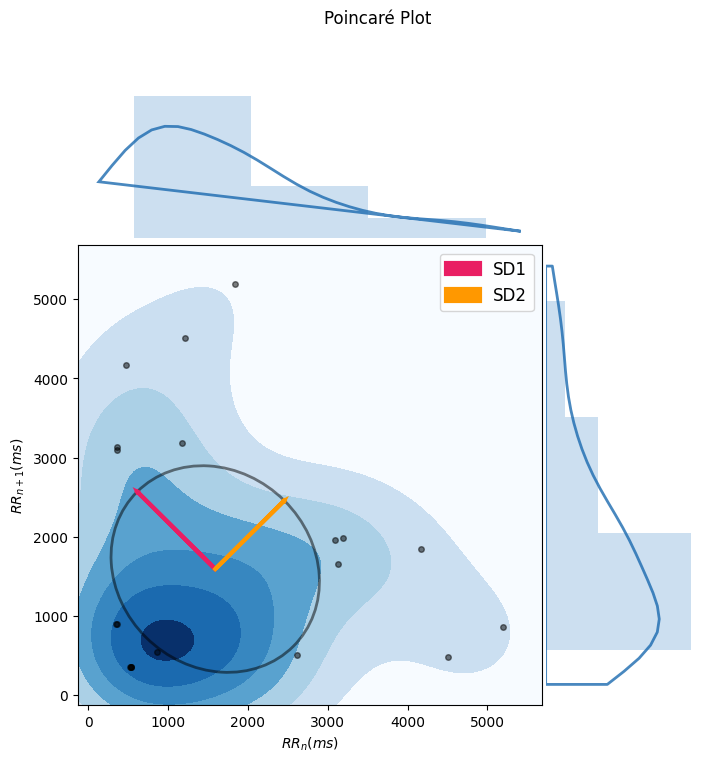

In [266]:
signal_rest = signal_full[-noload_time * SAMPLING_RATE:]
print(len(signal_rest) / SAMPLING_RATE)

peaks, info = nk.ecg_process(signal_rest, sampling_rate=SAMPLING_RATE)
hrv_nonlinear = nk.hrv_nonlinear(peaks, sampling_rate=SAMPLING_RATE, show=True)
hrv_nonlinear

120.0


/work/users/y/u/yuukias/env_conda/lib/python3.9/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,719.82806,921.323618,0.781298,2.083487e+06,1.279922,7.025761,4716.88869,0.721154,0.735294,0.92,...,1.264797,6.162227,1.384017,1.237447,1.141522,1.494545,1.049624,1.965043,2.670348,1.030837


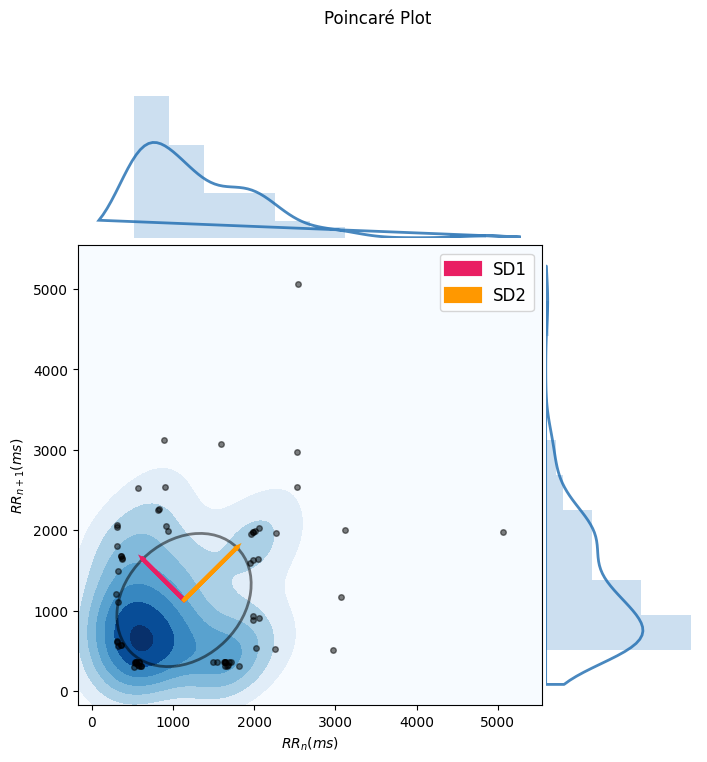

In [267]:
signal_constant = signal_full[steady_time*SAMPLING_RATE : (steady_time + constant_time)*SAMPLING_RATE]
print(len(signal_constant) / SAMPLING_RATE)

peaks, info = nk.ecg_process(signal_constant, sampling_rate=SAMPLING_RATE)
hrv_nonlinear = nk.hrv_nonlinear(peaks, sampling_rate=SAMPLING_RATE, show=True)
hrv_nonlinear